In [2]:
from kaggle import api

In [3]:
creds ='{"username":"naimcivan","key":"36c2d0e4d72f497775fb19831841cd78"}'

In [5]:
!kaggle competitions download -c tabular-playground-series-jan-2021


  0%|          | 0.00/62.8M [00:00<?, ?B/s]
  2%|1         | 1.00M/62.8M [00:00<00:09, 6.91MB/s]
  3%|3         | 2.00M/62.8M [00:00<00:09, 6.95MB/s]
  5%|4         | 3.00M/62.8M [00:00<00:08, 7.65MB/s]
  6%|6         | 4.00M/62.8M [00:00<00:07, 8.17MB/s]
  8%|7         | 5.00M/62.8M [00:00<00:08, 6.95MB/s]
 10%|9         | 6.00M/62.8M [00:00<00:08, 7.01MB/s]
 11%|#1        | 7.00M/62.8M [00:00<00:07, 7.59MB/s]
 13%|#2        | 8.00M/62.8M [00:01<00:07, 7.38MB/s]
 16%|#5        | 10.0M/62.8M [00:01<00:06, 8.13MB/s]
 18%|#7        | 11.0M/62.8M [00:01<00:08, 6.49MB/s]
 19%|#9        | 12.0M/62.8M [00:01<00:07, 7.16MB/s]
 21%|##        | 13.0M/62.8M [00:01<00:07, 6.93MB/s]
 22%|##2       | 14.0M/62.8M [00:01<00:06, 7.60MB/s]
 24%|##3       | 15.0M/62.8M [00:02<00:06, 8.09MB/s]
 25%|##5       | 16.0M/62.8M [00:02<00:05, 8.41MB/s]
 27%|##7       | 17.0M/62.8M [00:02<00:07, 6.80MB/s]
 29%|##8       | 18.0M/62.8M [00:02<00:07, 6.71MB/s]
 30%|###       | 19.0M/62.8M [00:02<00:07, 6.26MB/s]
 

# Problem Definition
In this challenge, we are asked to build a regression model. Without further context, we are given some features with continuous values to predict a continuous target. This way, we can practice on focussing on the data without requiring any specific domain knowledge because the column names cont# do not indicate any further information.

There is no missing data but instead we have a different obstacle that we have to overcome - bimodal distribution of the target variable and multimodal distributions of the features.

# Importing Libraries

In [15]:
!pip install lightgbm

You should consider upgrading via the 'c:\users\naim cavin\anaconda3\python.exe -m pip install --upgrade pip' command.


In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

C:\Users\Naim Cavin\anaconda3\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Naim Cavin\anaconda3\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [14]:
# Configurations
N_SPLITS = 5
SEED = 42

In [17]:
train_df = pd.read_csv('train.csv')
print('Train data dimension: ', train_df.shape)
test_df = pd.read_csv('test.csv')
print('Test data dimension: ', test_df.shape)

Train data dimension:  (300000, 16)
Test data dimension:  (200000, 15)


In [18]:
sample_submission = pd.read_csv("sample_submission.csv")
print('Sample submission dimension: ', sample_submission.shape)

Sample submission dimension:  (200000, 2)


In [20]:
print(f"Missing data in the train data: {train_df.isna().sum(axis=0).any()}")
print(f"Missing data in the test data: {test_df.isna().sum(axis=0).any()}")

Missing data in the train data: False
Missing data in the test data: False


In [22]:
train_df.head()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


# Modality
You can find the modality of a distribution by counting the number of its peaks. There are unimodal, bimodal and multimodal distributions. The most commonly known distribution is unimodal with only one peak. This is probably also the most comfortable distribution to work with. If you have two peaks, it is called bimodal, and if you have three or more peaks, then it is called multimodal.

Also, don't get it confused with "multimodal learning", which describes problems with mixed feature modalities, such as pictures and text.

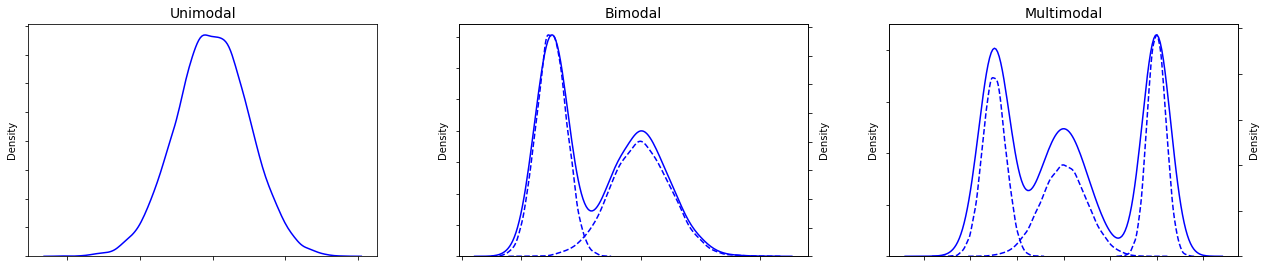

In [24]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

# Unimodal
sns.distplot(np.random.normal(10, 5, 10000), ax=ax[0], hist=False, color='blue')
ax[0].set_title('Unimodal', fontsize=14)
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])

# Bimodal
sample_bimodal = pd.DataFrame({'feature1' : np.random.normal(10, 5, 10000),
                   'feature2' : np.random.normal(40, 10, 10000),
                   'feature3' : np.random.randint(0, 2, 10000),
                  })

sample_bimodal['combined'] = sample_bimodal.apply(lambda x: x.feature1 if (x.feature3 == 0 ) else x.feature2, axis=1)

sns.distplot(sample_bimodal['combined'].values, ax=ax[1], color='blue', hist=False)

ax2 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis

sns.distplot(sample_bimodal.feature1, ax=ax2, color='blue', kde_kws={'linestyle':'--'}, hist=False)
sns.distplot((sample_bimodal.feature2), ax=ax2, color='blue', kde_kws={'linestyle':'--'}, hist=False)

f.tight_layout()  # otherwise the right y-label is slightly clipped

ax[1].set_title('Bimodal', fontsize=14)
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax2.set_yticklabels([])


# Multimodal
sample_multi = pd.DataFrame({'feature1' : np.random.normal(10, 5, 10000),
                   'feature2' : np.random.normal(40, 10, 10000),
                   'feature3' : np.random.randint(0, 3, 10000),
                               'feature4' : np.random.normal(80, 4, 10000),
                  })

sample_multi['combined'] = sample_multi.apply(lambda x: x.feature1 if (x.feature3 == 0 ) else (x.feature2 if x.feature3 == 1 else x.feature4), axis=1 )

sns.distplot(sample_multi['combined'].values, ax=ax[2], color='blue', hist=False)

ax3 = ax[2].twinx()  # instantiate a second axes that shares the same x-axis

sns.distplot(sample_multi.feature1, ax=ax3, color='blue', kde_kws={'linestyle':'--'}, hist=False)
sns.distplot((sample_multi.feature2), ax=ax3, color='blue', kde_kws={'linestyle':'--'}, hist=False)
sns.distplot((sample_multi.feature4), ax=ax3, color='blue', kde_kws={'linestyle':'--'}, hist=False)

f.tight_layout()  # otherwise the right y-label is slightly clipped

ax[2].set_title('Multimodal', fontsize=14)
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])
ax3.set_yticklabels([])

plt.show()

# Data Overview


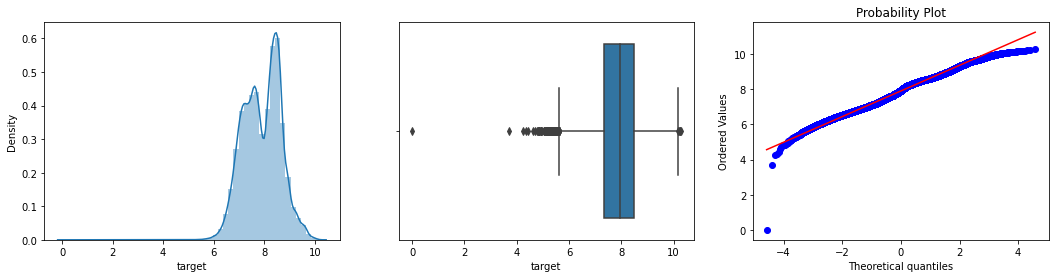

In [25]:
#display(train_df.target.describe())
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
sns.distplot(train_df.target, ax=ax[0])
sns.boxplot(train_df.target, ax=ax[1])
stats.probplot(train_df['target'], plot=ax[2])
plt.show()

# Target

- It looks like an overlay of two different distributions - when the data distribution has two peaks, it is called bimodal distribution.
- There is exactly one data point with a target value of 0 - this looks very much like an outlier. We should probably drop it since it is only one single data point.
- The data does not seem to be skewed and therefore does not necessarily need to be transformed (if non-tree-based models are used - for tree-based models this would not matter anyways).

In [26]:
# Drop one outlier
train_df = train_df[train_df.target != 0].reset_index(drop=True)

# Features
Let's look at the cont# features in bulk. For below plots we can see some odd distributions: all cont# features show multiple 'peaks' with no sign of a normal distribution.

Um, ok... what is going on?! We definitely need to dig deeper here before we can start building our model.

We already saw that our target variable has a bimodal distribution. Now we have some feature distributions with multiple peaks. This is called multimodal distribution.

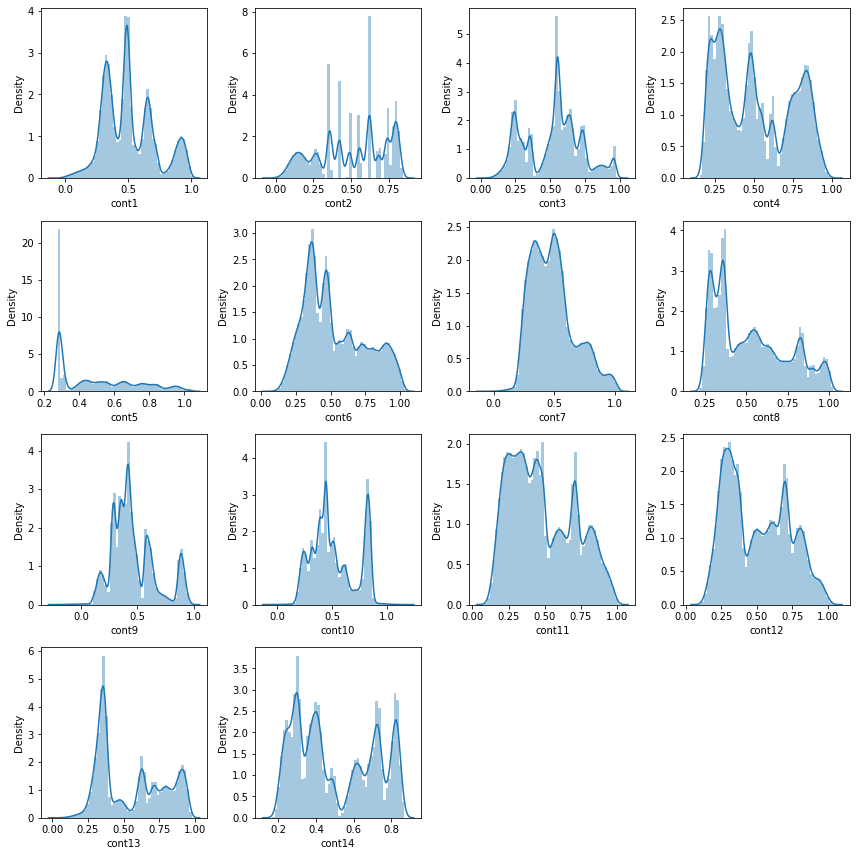

In [27]:
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
#f.suptitle('Distribution of Features', fontsize=16)
sns.distplot(train_df['cont1'], ax=ax[0, 0])
sns.distplot(train_df['cont2'], ax=ax[0, 1])
sns.distplot(train_df['cont3'], ax=ax[0, 2])
sns.distplot(train_df['cont4'], ax=ax[0, 3])

sns.distplot(train_df['cont5'], ax=ax[1, 0])
sns.distplot(train_df['cont6'], ax=ax[1, 1])
sns.distplot(train_df['cont7'], ax=ax[1, 2])
sns.distplot(train_df['cont8'], ax=ax[1, 3])

sns.distplot(train_df['cont9'], ax=ax[2, 0])
sns.distplot(train_df['cont10'], ax=ax[2, 1])
sns.distplot(train_df['cont11'], ax=ax[2, 2])
sns.distplot(train_df['cont12'], ax=ax[2, 3])

sns.distplot(train_df['cont13'], ax=ax[3, 0])
sns.distplot(train_df['cont14'], ax=ax[3, 1])
f.delaxes(ax[3, 2])
f.delaxes(ax[3, 3])
plt.tight_layout()
plt.show()

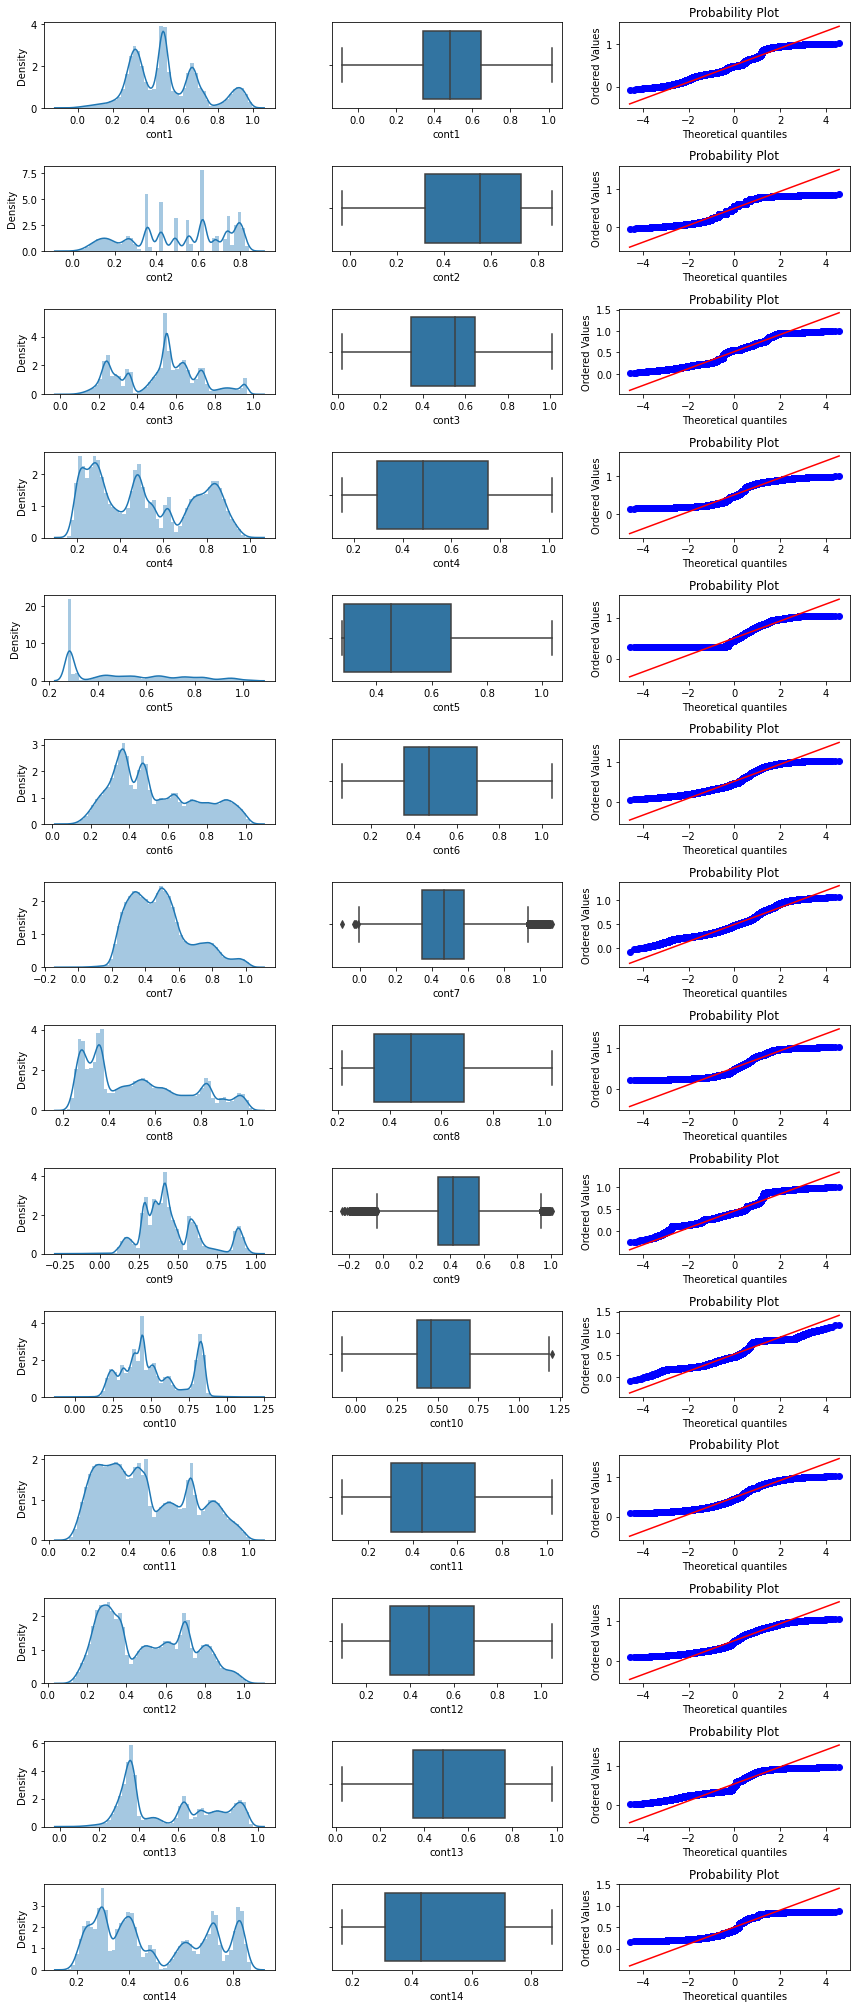

In [28]:
f, ax = plt.subplots(nrows=14, ncols=3, figsize=(12, 28))
for i, var in enumerate(train_df.columns[train_df.columns.str.startswith('cont')]):
    sns.distplot(train_df[var], ax=ax[i, 0])
    sns.boxplot(train_df[var], ax=ax[i, 1])
    stats.probplot(train_df[var], plot=ax[i, 2])
plt.tight_layout()
plt.show()

From a top level point of view, we can see that none of the features seem to be correlated to the target.
Additionally, there seems to be a highly correlated cluster consisting of cont1 and cont6 through cont13.

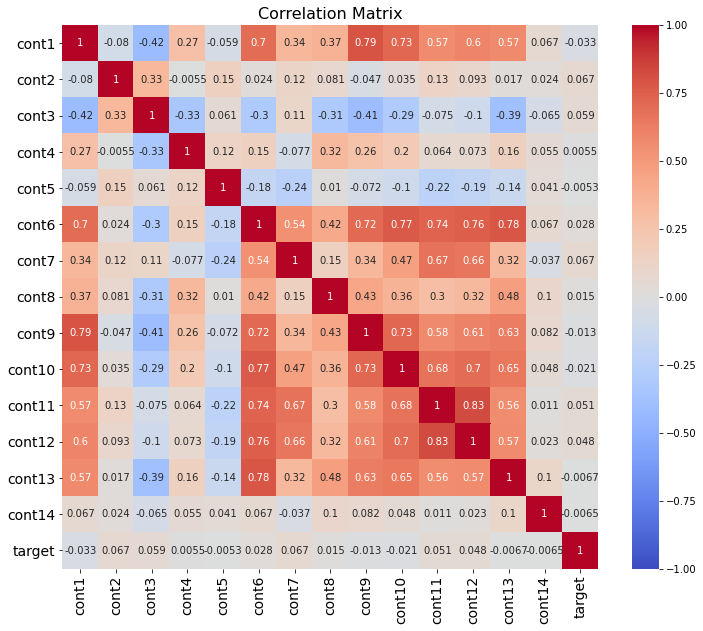

In [29]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title("Correlation Matrix", fontsize=16)
sns.heatmap(train_df[train_df.columns[train_df.columns != 'id']].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    tick.label.set_rotation(90) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(0) 
plt.show()

# Model Baseline
Although, we did not do any feature engineering so far, let's create a simple LightGBM baseline to get a benchmark first.

In [30]:
model_params = {
    "objective": "root_mean_squared_error",
    "learning_rate": 0.1, 
    "seed": 42,
    'max_depth': 7,
    'colsample_bytree': .85,
    "subsample": .85,
}
    
train_params = {
    "early_stopping_rounds": 100,
    "verbose_eval": 50,
}

def visualize_results(y_pred, y_train, features, feature_importances):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    color = 'blue'
    ax[0].set_ylabel('Ground Truth', color=color, fontsize=14)
    sns.distplot(y_train, ax=ax[0], color=color)
    ax[0].tick_params(axis='y', labelcolor=color)

    ax2 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'red'
    ax2.set_ylabel('Predicted', color=color, fontsize=14)  # we already handled the x-label with ax1
    sns.distplot(pd.Series(y_pred), ax=ax2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax[0].set_title('Distribution of Predicted Values and Ground Truth', fontsize=16)

    pd.DataFrame({'features' : features, 
                  'feature_importance': feature_importances}
                ).set_index('features').sort_values(by='feature_importance', ascending=False).head(10).plot(kind='bar', ax=ax[1])
    ax[1].set_title('Top 10 Most Important Features', fontsize=16)

    for tick in ax[1].yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
        tick.label.set_rotation(0) 

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772


Fold 1:
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 239999, number of used features: 14
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 7.906033
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.704025	valid_1's rmse: 0.705396
[100]	training's rmse: 0.696431	valid_1's rmse: 0.701342
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.696431	v

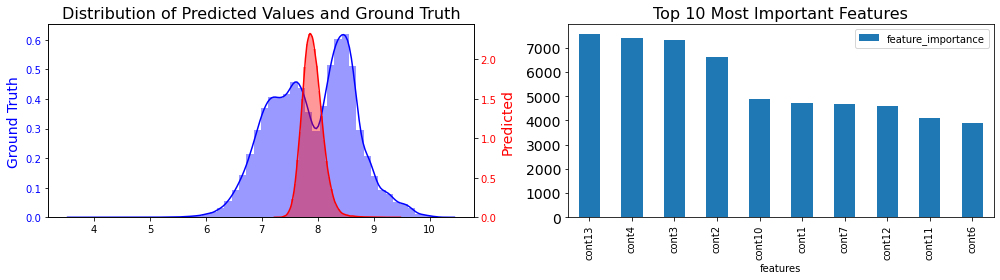

In [31]:
def run_model(X, y, X_test):
    """
    Baseline is based on
    https://www.kaggle.com/ttahara/tps-jan-2021-gbdts-baseline
    
    Arg:
    * X: training data containing features
    * y: training data containing target variables
    * X_test: test data to predict
    
    Returns:
    * Y_test: predictions for X_test
    """
    # Initialize variables
    y_oof_pred = np.zeros(len(X))
    y_test_pred = np.zeros(len(X_test))

    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)


    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"Fold {fold + 1}:")

        # Prepare training and validation data
        X_train = X.iloc[train_idx].reset_index(drop=True)
        X_val = X.iloc[val_idx].reset_index(drop=True)

        y_train = y.iloc[train_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)  

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)

        # Define model
        model = lgb.train(params=model_params,
                          train_set=train_data,
                          valid_sets=[train_data, val_data],
                          **train_params)

        # Calculate evaluation metric: Root Mean Squared Error (RMSE)
        y_val_pred = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_val_pred))
        print(f"RMSE: {score:.5f}\n")

        y_oof_pred[val_idx] = y_val_pred

        # Make predictions
        y_test_pred += model.predict(X_test)

    # Calculate evaluation metric for out of fold validation set
    oof_score = np.sqrt(mean_squared_error(y, y_oof_pred))
    print(f"OOF RMSE: {oof_score: 5f}")

    # Average predictions over all folds
    y_test_pred = y_test_pred / N_SPLITS
    visualize_results(y_oof_pred, y, X.columns, model.feature_importance(importance_type="gain"))

    return y_test_pred


features_baseline = train_df.columns[train_df.columns.str.startswith('cont')]
target = ['target']

display(train_df[features_baseline].head().style.set_caption('Training data'))

y_pred = run_model(train_df[features_baseline], 
                   train_df[target], 
                   test_df[features_baseline])

The out of fold (OOF) RMSE score is 0.703148 - this is our benchmark for the next steps. This score is quite bad since RMSE of 0 would be ideal. If we look at the distributions of our predictions versus the ground truth, we can see that our model is doing quite poorly.

# Can tree-based models handle bimodal distributions?

 Yes, tree-based models in general should be able to handle bimodal distributions.

Decision trees are insensitive to the targets distribution. Therefore, we do not necessarily need to transform the target to fit a normal distribution. Therefore, we would expect tree-based models to be able to handle bimodal distributions without any transformations as well.

# Feature Engineering Techniques
We have seen that our baseline model in theory is able to model the bimodal distribution of our target. However, we can also see that this highly depends on the quality of our features. In the Data Overview, we saw that the features have a low absolute correlation to the target. In this section, we will be exploring different feature engineering techniques.

### 1) Gaussian Mixture Modelling (GMM)

We can use Gaussian Mixture Modelling to separate the two distributions. It is an unsupervised learning algorithm.

In [33]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)

gmm.fit(train_df.target.values.reshape(-1, 1))

train_df['target_class'] = gmm.predict(train_df.target.values.reshape(-1, 1))

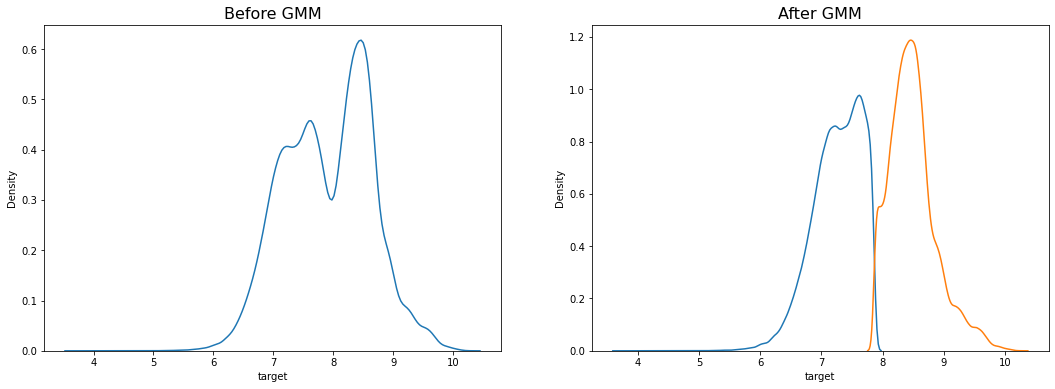

In [34]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.kdeplot(data=train_df.target, ax=ax[0])
ax[0].set_title('Before GMM', fontsize=16)
sns.kdeplot(data=train_df[train_df.target_class==0].target, label='Component 1', ax=ax[1])
sns.kdeplot(data=train_df[train_df.target_class==1].target, label='Component 2', ax=ax[1])
ax[1].set_title('After GMM', fontsize=16)
plt.show()

Since the features have multimodal distributions, it would be worthwhile checking what happens if we add a GMM feature for each cont# feature.

In [35]:
def get_gmm_class_feature(feat, n):
    gmm = GaussianMixture(n_components=n, random_state=42)

    gmm.fit(train_df[feat].values.reshape(-1, 1))

    train_df[f'{feat}_class'] = gmm.predict(train_df[feat].values.reshape(-1, 1))
    test_df[f'{feat}_class'] = gmm.predict(test_df[feat].values.reshape(-1, 1))

get_gmm_class_feature('cont1', 4)
get_gmm_class_feature('cont2', 10)
get_gmm_class_feature('cont3', 6)
get_gmm_class_feature('cont4', 4)
get_gmm_class_feature('cont5', 3)
get_gmm_class_feature('cont6', 2)
get_gmm_class_feature('cont7', 3)
get_gmm_class_feature('cont8', 4)
get_gmm_class_feature('cont9', 4)
get_gmm_class_feature('cont10', 8)
get_gmm_class_feature('cont11', 5)
get_gmm_class_feature('cont12', 4)
get_gmm_class_feature('cont13', 6)
get_gmm_class_feature('cont14', 6)

train_df.head()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cont5_class,cont6_class,cont7_class,cont8_class,cont9_class,cont10_class,cont11_class,cont12_class,cont13_class,cont14_class
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,...,0,1,2,0,2,7,4,2,2,2
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,...,1,0,0,2,3,0,3,0,1,0
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,...,1,1,0,2,2,1,1,1,2,2
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,...,0,1,2,1,2,4,1,2,2,2
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,...,1,1,0,2,1,7,4,2,2,0


,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,cont1_class,cont2_class,cont3_class,cont4_class,cont5_class,cont6_class,cont7_class,cont8_class,cont9_class,cont10_class,cont11_class,cont12_class,cont13_class,cont14_class
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,2,5,4,0,0,1,2,0,2,7,4,2,2,2
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,3,7,4,2,1,0,0,2,3,0,3,0,1,0
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,1,4,5,0,1,1,0,2,2,1,1,1,2,2
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,1,2,0,1,0,1,2,1,2,4,1,2,2,2
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,1,8,5,3,1,1,0,2,1,7,4,2,2,0


Fold 1:
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3639
[LightGBM] [Info] Number of data points in the train set: 239999, number of used features: 28
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 7.906033
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.703875	valid_1's rmse: 0.705417
[100]	training's rmse: 0.696126	valid_1's rmse: 0.701155
Did not meet earl

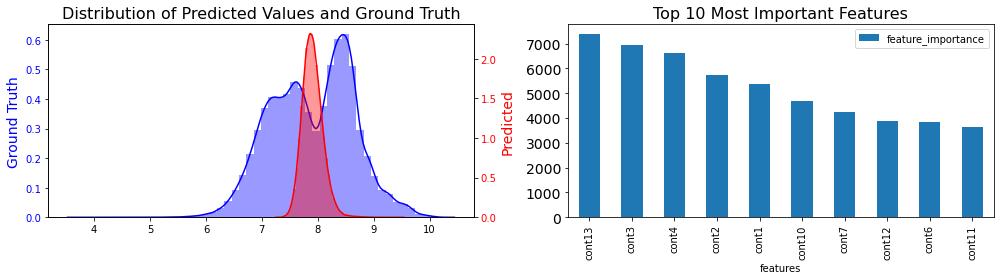

In [38]:
features = list(features_baseline) + list(train_df.columns[train_df.columns.str.contains('class') & ~train_df.columns.str.contains('target')])
target = ['target']

display(train_df[features].head().style.set_caption('Training data'))

y_test_pred = run_model(train_df[features], 
          train_df[target], 
          test_df[features])

With the newly added features, we get a RMSE of 0.703054. This is only a 0.000094 improvement to our baseline and our distribution is still not close to the distribution of the ground truth.

Let's try another idea: What happens if we use the classes we got from the GMM to separate each feature:

In [39]:
for j in range(1,15):
    for i in range(train_df.cont1_class.nunique()):
        train_df[f'cont{j}_class_{i+1}'] = np.where(train_df[f'cont{j}_class'] == (i+1), train_df[f'cont{j}'], np.nan)
        test_df[f'cont{j}_class_{i+1}'] = np.where(test_df[f'cont{j}_class'] == (i+1), test_df[f'cont{j}'], np.nan)

In [40]:
train_df[['cont1', 'cont1_class', 'cont1_class_1', 'cont1_class_2', 'cont1_class_3']].head().style.set_caption('Example of newly created features for cont1 from cont1_class')

,cont1,cont1_class,cont1_class_1,cont1_class_2,cont1_class_3
0,0.670390,2,nan,0.670390,nan
1,0.388053,3,nan,nan,0.388053
2,0.834950,1,0.834950,nan,nan
3,0.820708,1,0.820708,nan,nan
4,0.935278,1,0.935278,nan,nan


,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,cont1_class_1,cont1_class_2,cont1_class_3,cont1_class_4,cont2_class_1,cont2_class_2,cont2_class_3,cont2_class_4,cont3_class_1,cont3_class_2,cont3_class_3,cont3_class_4,cont4_class_1,cont4_class_2,cont4_class_3,cont4_class_4,cont5_class_1,cont5_class_2,cont5_class_3,cont5_class_4,cont6_class_1,cont6_class_2,cont6_class_3,cont6_class_4,cont7_class_1,cont7_class_2,cont7_class_3,cont7_class_4,cont8_class_1,cont8_class_2,cont8_class_3,cont8_class_4,cont9_class_1,cont9_class_2,cont9_class_3,cont9_class_4,cont10_class_1,cont10_class_2,cont10_class_3,cont10_class_4,cont11_class_1,cont11_class_2,cont11_class_3,cont11_class_4,cont12_class_1,cont12_class_2,cont12_class_3,cont12_class_4,cont13_class_1,cont13_class_2,cont13_class_3,cont13_class_4,cont14_class_1,cont14_class_2,cont14_class_3,cont14_class_4
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,nan,0.670390,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.643968,nan,nan,nan,nan,nan,nan,nan,nan,0.855953,nan,nan,nan,nan,0.890700,nan,nan,nan,nan,nan,nan,nan,0.558245,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.921832,nan,0.866772,nan,nan,nan,0.878733,nan,nan,nan,0.305411,nan,nan
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,nan,nan,0.388053,nan,nan,nan,nan,nan,nan,nan,nan,0.686102,nan,0.501149,nan,nan,0.643790,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.580748,nan,nan,nan,nan,0.418335,nan,nan,nan,nan,nan,nan,nan,0.439872,nan,nan,nan,nan,nan,0.369957,nan,nan,nan,nan,nan,nan,nan
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,0.834950,nan,nan,nan,nan,nan,nan,0.227436,nan,nan,nan,nan,nan,nan,nan,nan,0.606839,nan,nan,nan,0.829175,nan,nan,nan,nan,nan,nan,nan,nan,0.558771,nan,nan,nan,0.587603,nan,nan,0.823312,nan,nan,nan,0.567007,nan,nan,nan,0.677708,nan,nan,nan,nan,0.882938,nan,nan,nan,0.303047,nan,nan
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,0.820708,nan,nan,nan,nan,0.160155,nan,nan,nan,nan,nan,nan,0.726104,nan,nan,nan,nan,nan,nan,nan,0.785108,nan,nan,nan,nan,0.752758,nan,nan,0.823267,nan,nan,nan,nan,0.574466,nan,nan,nan,nan,nan,0.580843,0.769594,nan,nan,nan,nan,0.818143,nan,nan,nan,0.914281,nan,nan,nan,0.279528,nan,nan
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,0.935278,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.880214,nan,0.665610,nan,nan,nan,0.830131,nan,nan,nan,nan,nan,nan,nan,nan,0.604157,nan,nan,0.874658,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.983575,nan,0.900464,nan,nan,nan,0.935918,nan,nan,nan,nan,nan,nan


Fold 1:
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14790
[LightGBM] [Info] Number of data points in the train set: 239999, number of used features: 58
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 7.906033
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.702776	valid_1's rmse: 0.70521
[100]	training's rmse: 0.694591	valid_1's rmse: 0.701356
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.694591	v

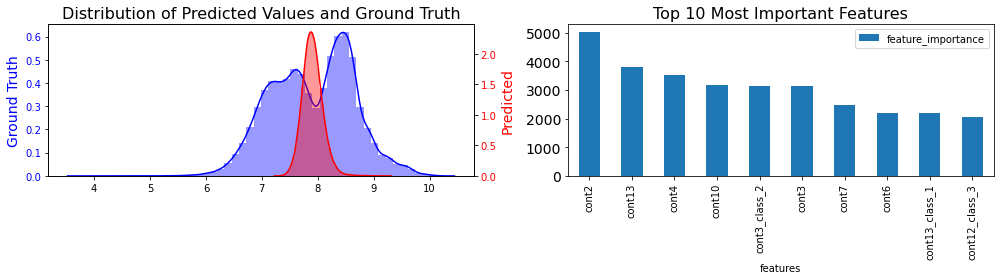

In [43]:
features = list(features_baseline) + list(train_df.columns[train_df.columns.str.contains('class_')])
target = ['target']

display(train_df[features].head().style.set_caption('Training data'))

y_test_pred = run_model(train_df[features], 
          train_df[target], 
          test_df[features])